<a href="https://colab.research.google.com/github/joshmurr/machine-learnings/blob/master/cci-dsai/StyleGAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StyleGAN 2

This notebook takes some work from [this notebook](https://colab.research.google.com/drive/1ShgW6wohEFQtqs_znMna3dzrcVoABKIH) developed my Mikael Christensen in 2019 and [this notebook](https://amarsaini.github.io/Epoching-Blog/jupyter/2020/08/10/Latent-Space-Exploration-with-StyleGAN2.html) developed by Amar Saini in 2020.

For information on StyleGAN2, see:

- Paper: https://arxiv.org/abs/1812.04948
- Video: https://youtu.be/kSLJriaOumA
- Code: https://github.com/NVlabs/stylegan
- FFHQ: https://github.com/NVlabs/ffhq-dataset


First we import Tensorflow and the [StyleGAN2 Github repository](https://github.com/NVlabs/stylegan2.git). We have to use Tensorflow 1.x as that is what was used to build StyleGAN 2.

In [1]:
%tensorflow_version 1.x
import tensorflow as tf

# Download the code
!git clone https://github.com/NVlabs/stylegan2.git
%cd stylegan2

TensorFlow 1.x selected.
Cloning into 'stylegan2'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 138 (delta 4), reused 10 (delta 4), pack-reused 127
Receiving objects: 100% (138/138), 599.47 KiB | 4.61 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/stylegan2


In [2]:
# Various imports and setup
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

from pathlib import Path
from PIL import Image
import pickle
import numpy as np

import ipywidgets as widgets
from tqdm import tqdm

import pretrained_networks

try:
  from google.colab import files
except ImportError:
  pass

fps = 20
results_size = 400

# Choose between these pretrained models - I think 'f' is the best choice:
pretrained = {
  # 1024×1024 faces
  'faces_a': 'stylegan2-ffhq-config-a.pkl',
  'faces_b': 'stylegan2-ffhq-config-b.pkl',
  'faces_c': 'stylegan2-ffhq-config-c.pkl',
  'faces_d': 'stylegan2-ffhq-config-d.pkl',
  'faces_e': 'stylegan2-ffhq-config-e.pkl',
  'faces_f': 'stylegan2-ffhq-config-f.pkl',

  # 512×384 cars
  'cars_a': 'stylegan2-car-config-a.pkl',
  'cars_b': 'stylegan2-car-config-b.pkl',
  'cars_c': 'stylegan2-car-config-c.pkl',
  'cars_d': 'stylegan2-car-config-d.pkl',
  'cars_e': 'stylegan2-car-config-e.pkl',
  'cars_f': 'stylegan2-car-config-f.pkl',

  # 256x256 horses
  'horses_a': 'stylegan2-horse-config-a.pkl',
  'horses_b': 'stylegan2-horse-config-f.pkl',

  # 256x256 churches
  'churches_a': 'stylegan2-church-config-a.pkl',
  'churches_b': 'stylegan2-church-config-f.pkl',

  # 256x256 cats
  'cats_a': 'stylegan2-cat-config-f.pkl',
  'cats_b': 'stylegan2-cat-config-a.pkl',
}

In [3]:
#collapse-hide

# Code to load the StyleGAN2 Model
def load_model(model_path):
    _G, _D, Gs = pretrained_networks.load_networks('gdrive:networks/' + model_path)
    
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
    
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    
    return Gs, noise_vars, Gs_kwargs

# Generate images given a random seed (Integer)
def generate_image_random(rand_seed):
    rnd = np.random.RandomState(rand_seed)
    z = rnd.randn(1, *Gs.input_shape[1:])
    tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars})
    images = Gs.run(z, None, **Gs_kwargs)
    return images, z

# Generate images given a latent code ( vector of size [1, 512] )
def generate_image_from_z(z):
    images = Gs.run(z, None, **Gs_kwargs)
    return images

# Choose a Pretrained Model

Have a look at the [dict](https://www.w3schools.com/python/python_dictionaries.asp) a few cells before which has a long list of all the different StyleGAN2 pretrained models you can download. Choose one a put the relevant keyword in the call to `load_model()` below.

In [4]:
# Loading the StyleGAN2 Model!
Gs, noise_vars, Gs_kwargs = load_model(pretrained['faces_f'])

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


We use a random seed to generate an image so that we can recreate it. We also store the latent vector in `latent_z1`.

We turn the image into a [PIL](https://pypi.org/project/Pillow/) (Python Image Library) image. In an interactive Python notebook like this we can just type the name of the image and the notebook will display it.

<class 'PIL.Image.Image'>


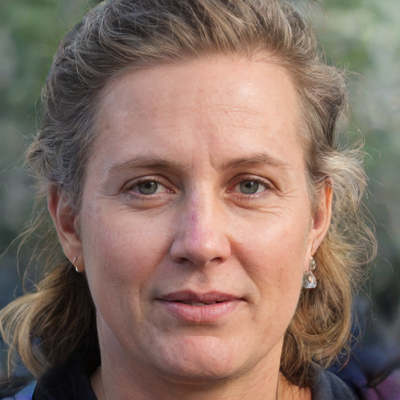

In [7]:
# Ask the generator to make an output, given a random seed number
images, latent_z1 = generate_image_random(896758675)
image1 = Image.fromarray(images[0]).resize((results_size, results_size))
print(type(image1))
image1

To demonstrate that we can generate the same image using the latent vector we stored in `latent_z1`, we can pass that into `generate_image_from_z()` and get the same image.

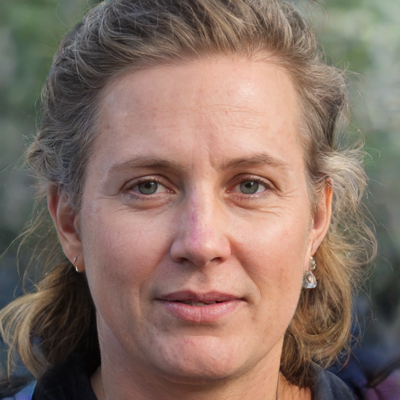

In [8]:
image1_copy = generate_image_from_z(latent_z1)
image1_copy = Image.fromarray(image1_copy[0]).resize((results_size, results_size))
image1_copy

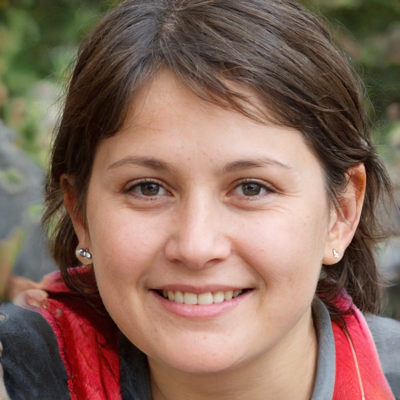

In [9]:
image2, latent_z2 = generate_image_random(547)
image2 = Image.fromarray(image2[0]).resize((results_size, results_size))
image2

# Linear Interpolation

Here you can see how simple the formula for a linear interpolation is. You're just mixing the two vectors by a certain ratio `alpha`.

In [10]:
def linear_interpolate(code1, code2, alpha):
    return code1 * alpha + code2 * (1 - alpha)

Lets interpolate between the two vectors we found above.

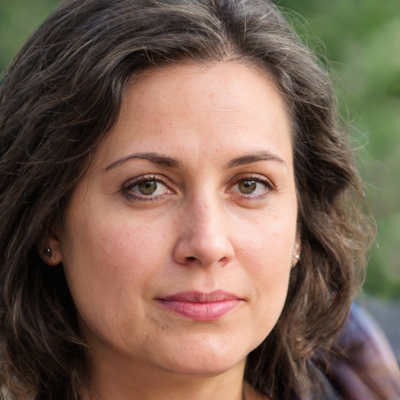

In [11]:
interpolated_latent_code = linear_interpolate(latent_z1, latent_z2, 0.5)

images = generate_image_from_z(interpolated_latent_code)
Image.fromarray(images[0]).resize((results_size, results_size))

### Make a GIF

To make a video (or a GIF) we just have to step along our interpolated path by adjusting `alpha` from `0 -> 1` and running the generator for each interpolated point. `step_size` is the amount we are incrementing `alpha` by in each step.

We add all these generated images into an array and then can convert this array into a GIF quite simply.

In [12]:
output_gifs_path = Path('output_gifs')
# Make Output Gifs folder if it doesn't exist.
if not output_gifs_path.exists():
    output_gifs_path.mkdir()

In [13]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def make_latent_interp_animation(code1, code2, img1, img2, num_interps, size=(200,200), name='latent_space_traversal.gif'):
    
    step_size = 1.0/num_interps
    
    all_imgs = []
    
    amounts = np.arange(0, 1, step_size)

    img1_resize = img1.resize(size)
    img2_resize = img2.resize(size)
    
    for alpha in tqdm(amounts):
        interpolated_latent_code = linear_interpolate(code1, code2, alpha)
        images = generate_image_from_z(interpolated_latent_code)
        interp_latent_image = Image.fromarray(images[0]).resize((200, 200))
        frame = get_concat_h(img1_resize, interp_latent_image)
        frame = get_concat_h(frame, img2_resize)
        all_imgs.append(frame)

    save_name = output_gifs_path/name
    all_imgs[0].save(save_name, save_all=True, append_images=all_imgs[1:], duration=1000/fps, loop=0)

The output `.gif` will save in `stylegan2/output_gifs`.

In [14]:
make_latent_interp_animation(latent_z1, latent_z2, image1, image2, num_interps=100, name='linear_interpolate.gif')

100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


# Projecting into Latent Space

This process is a bit more complex than when we did it with ProGAN. Fortunately NVIDIA have given us a Python script which does the hard work for us and is called `run_projector.py`.

This script performs the process explained in the lecture using a VGG16 network as a feature extractor.

Upload one (or more images) below and they will be saved to `'stylegan2/uploaded_images'`.

> __Make sure the image is at least 640x380 px in size!!__

In [27]:
uploaded_images_path = Path('uploaded_images')
aligned_images_path = Path('aligned_imgs')

if not uploaded_images_path.exists():
    uploaded_images_path.mkdir()

if not aligned_images_path.exists():
    aligned_images_path.mkdir()

def upload_image():
  uploaded = files.upload()
  name = list(uploaded.keys())[0]
  b64 = uploaded[name]
  image = imageio.imread(b64)
  image = imageio.imwrite(uploaded_images_path/name, image)

upload_image()

Saving 2021-11-05-160435.jpg to 2021-11-05-160435 (1).jpg


### Align Faces

To get the best results we need to align the faces in our uploaded image the same way the faces are aligned in the __FFHQ__ dataset. To do this we use OpenCV and a facial landmark detection model. We need to download that model first...

In [17]:
# One-Time Download of Facial Landmark Detection Model Weights
if not Path('shape_predictor_68_face_landmarks.dat').exists():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dv shape_predictor_68_face_landmarks.dat.bz2

--2021-11-12 14:40:26--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  20.9MB/s    in 2.9s    

2021-11-12 14:40:29 (20.9 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

  shape_predictor_68_face_landmarks.dat.bz2: done


Next we download a helpful Python script developed by the authors of [this article](https://amarsaini.github.io/Epoching-Blog/jupyter/2020/08/10/Latent-Space-Exploration-with-StyleGAN2.html)

In [18]:
!wget https://raw.githubusercontent.com/AmarSaini/Epoching_StyleGan2_Setup/master/align_face.py

--2021-11-12 14:42:25--  https://raw.githubusercontent.com/AmarSaini/Epoching_StyleGan2_Setup/master/align_face.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085 (5.0K) [text/plain]
Saving to: ‘align_face.py’

align_face.py       100%[===================>]   4.97K  --.-KB/s    in 0s      

2021-11-12 14:42:25 (52.7 MB/s) - ‘align_face.py’ saved [5085/5085]



We use that script to align the faces in the images we uploaded.

In [28]:
from align_face import align_face

# Align all of our images using a landmark detection model!
all_imgs = list(uploaded_images_path.iterdir())
for img in all_imgs:
  if 'ipynb' not in img.name:
    align_face(str(img)).save(aligned_images_path/('aligned_'+img.name))

Number of faces detected: 1
Detection 0: Left: 216 Top: 167 Right: 439 Bottom: 390
Part 0: (212, 247), Part 1: (218, 275) ...


Finally, just to make sure it's all worked ok, we concatenate the uploaded image with the aligned version. This doesn't always work so it's worth checking!

In [32]:
aligned_img_set = list(aligned_images_path.iterdir())
aligned_img_set.sort()
aligned_img_set = [Image.open(x) for x in aligned_img_set if 'ipynb' not in x.name]

orig_img_set = list(uploaded_images_path.iterdir())
orig_img_set = [image for image in orig_img_set if 'ipynb' not in image.name]
orig_img_set.sort()
orig_img_set = [Image.open(x) for x in orig_img_set]

If you uploaded multiple images you will have to specify which image you want in the list.

I used a variable `k` to make this explicit.

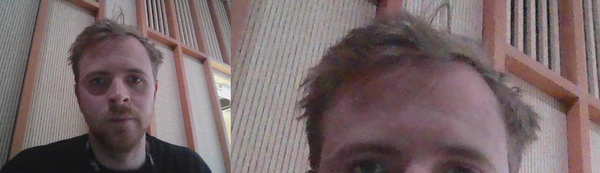

In [33]:
k = 0

pair = get_concat_h(orig_img_set[k], aligned_img_set[k])

basewidth = 600
wpercent = (basewidth / float(pair.size[0]))
hsize = int((float(pair.size[1]) * float(wpercent)))
pair = pair.resize((basewidth, hsize), Image.ANTIALIAS)

pair

We have to use another Python script which NVIDIA have bundled in the Github repo called `'dataset_tool.py'` to turn our images into official Tensorflow datasets. It's not as simple as just giving the model an image.

In [34]:
!python -W ignore dataset_tool.py create_from_images datasets_stylegan2/custom_imgs aligned_imgs/

Loading images from "aligned_imgs/"
Creating dataset "datasets_stylegan2/custom_imgs"
Added 1 images.


We also need to respecify a network to perform the optimising process.

But this could be any model from the list at the top... Hmmm??

In [35]:
model_path = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
num_images = 1

Now we use the script `'run_projector.py'` to project into the 'latent manifold'. The script saves an image at each step into the folder '`stylegan2/results'`.

__This takes about 10-15 minutes to complete.__

In [36]:
!python -W ignore run_projector.py project-real-images --network=$model_path \
  --dataset=custom_imgs --data-dir=datasets_stylegan2 --num-images=$num_images --num-snapshots 500

Local submit - run_dir: results/00000-project-real-images
dnnlib: Running run_projector.project_real_images() on localhost...
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from "custom_imgs"...
tcmalloc: large alloc 4294967296 bytes == 0x55d0c8c24000 @  0x7f2daebfc001 0x7f2dac77a54f 0x7f2dac7cab58 0x7f2dac7ceb17 0x7f2dac86d203 0x55d07b3e7544 0x55d07b3e7240 0x55d07b45b627 0x55d07b455ced 0x55d07b3e948c 0x55d07b42a159 0x55d07b4270a4 0x55d07b3e9698 0x55d07b457fe4 0x55d07b4559ee 0x55d07b3e8bda 0x55d07b457737 0x55d07b4559ee 0x55d07b327e2b 0x55d07b457fe4 0x55d07b3e8afa 0x55d07b456915 0x55d07b3e8afa 0x55d07b456c0d 0x55d07b4559ee 0x55d07b327e2b 0x55d07b457fe4 0x55d07b3e8afa 0x55d07b456915 0x55d07b4559ee 0x55d07b4556f3
tcmalloc: large alloc 4294967296 bytes == 0x55d1c8c24000 @  0x7f2daebfa1e7 0x

We can turn all these images into a GIF of course!

In [ ]:
def make_project_progress_gifs():
    all_result_folders = list(Path('results/').iterdir())
    all_result_folders.sort()

    last_result_folder = all_result_folders[-1]
    
    for img_num in range(num_images):
        all_step_pngs = [x for x in last_result_folder.iterdir() if x.name.endswith('png') and 'image{0:04d}'.format(img_num) in x.name]
        all_step_pngs.sort()

        target_image = Image.open(all_step_pngs[-1]).resize((results_size, results_size))

        all_concat_imgs = []
        for step_img_path in all_step_pngs[:-1]:
            step_img = Image.open(step_img_path).resize((results_size, results_size))
            all_concat_imgs.append(get_concat_h(target_image, step_img))

        all_concat_imgs[0].save('output_gifs/image{0:04d}_project_progress.gif'.format(img_num), save_all=True, append_images=all_concat_imgs[1:], duration=1000/fps, loop=0)

Your GIF(s) will be saved to `'stylegan2/output_gifs'`.

In [ ]:
make_project_progress_gifs()

Make an `MP4` video - this will automatically download when completed:

In [ ]:
path = '/content/stylegan2/results/00000-project-real-images/image0000-step%*.png'

!ffmpeg -r 25 -f image2 -s 1024x1024 -start_number 2 -i $path -vcodec libx264 -crf 25  -pix_fmt yuv420p results/my_face.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

# Extra: Save You Results to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r /content/stylegan2/results /content/drive/MyDrive/
!cp -r /content/stylegan2/output_gifs /content/drive/MyDrive/